# Data exploration

In [1]:
from typing import Tuple
import pandas as pd
import sys
sys.path.append("../") # go to parent dir

def load_datasets(storage_folder) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return [pd.read_pickle(storage_folder / f'{phase}_beatmaps.pkl') for phase in
            ['train', 'val', 'test']]

In [2]:
from IPython.display import display, Markdown, Latex

def dataset_stats(df: pd.DataFrame):
    # 1/2 of snippets are overlapping
    group_over = ['name', 'difficulty', 'snippet', 'time', ]
    for end_index in range(1, len(group_over) + 1):
        print(f"{df.groupby(group_over[:end_index]).ngroups:9} unique {' × '.join(group_over[:end_index])}")
    
    print(f"{df.groupby(['name']).apply(lambda x: x.index.to_frame()['time'].max()).sum() / 3600:9.2f} "
          'hours of unique audio')
    print(f"{df.groupby(['name', 'difficulty']).apply(lambda x: x.index.to_frame()['time'].max()).sum() / 3600:9.2f} "
          'hours of unique gameplay')
    print(f"{len(df['word'].unique()):9} unique actions")

def whole_dataset_stats(train, val, test):
    display(Markdown('### Train'))
    dataset_stats(train)
    display(Markdown('### Validation'))
    dataset_stats(val)
    display(Markdown('### Test'))
    dataset_stats(test)
    display(Markdown('### Unique actions overlap'))
    print(f'{len(set(val.word.unique()) - set(train.word.unique())):9} unique actions in validation compared to train')
    print(f'{len(set(test.word.unique()) - set(train.word.unique()) - set(val.word.unique())):9} unique actions in test compared to train and validation')

In [3]:
from pathlib import Path

In [105]:
display(Markdown('## Our dataset'))
storage_folder = Path('../../data/old_datasets')
whole_dataset_stats(*load_datasets(storage_folder))

display(Markdown('## OxAI dataset'))
storage_folder = Path('../../data/new_datasets')
whole_dataset_stats(*load_datasets(storage_folder))

## Our dataset

### Train

      705 unique name
     1615 unique name × difficulty
    33883 unique name × difficulty × snippet
  1694150 unique name × difficulty × snippet × time
    38.07 hours of unique audio
    86.68 hours of unique gameplay
     2449 unique actions


### Validation

       86 unique name
      182 unique name × difficulty
     3779 unique name × difficulty × snippet
   188950 unique name × difficulty × snippet × time
     4.49 hours of unique audio
     9.22 hours of unique gameplay
      924 unique actions


### Test

       78 unique name
      179 unique name × difficulty
     4039 unique name × difficulty × snippet
   201950 unique name × difficulty × snippet × time
     4.23 hours of unique audio
     9.36 hours of unique gameplay
      946 unique actions


### Unique actions overlap

       96 unique actions in validation compared to train
       99 unique actions in test compared to train and validation


## OxAI dataset

### Train

      613 unique name
     1499 unique name × difficulty
    36141 unique name × difficulty × snippet
  1807050 unique name × difficulty × snippet × time
    32.48 hours of unique audio
    77.61 hours of unique gameplay
     2489 unique actions


### Validation

       80 unique name
      197 unique name × difficulty
     4927 unique name × difficulty × snippet
   246350 unique name × difficulty × snippet × time
     4.28 hours of unique audio
    10.40 hours of unique gameplay
     1060 unique actions


### Test

       72 unique name
      152 unique name × difficulty
     3916 unique name × difficulty × snippet
   195800 unique name × difficulty × snippet × time
     3.93 hours of unique audio
     8.19 hours of unique gameplay
      981 unique actions


### Unique actions overlap

      105 unique actions in validation compared to train
       79 unique actions in test compared to train and validation


## Number of beat elements per action

In [204]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})

def plot_action_distro(df: pd.DataFrame):
    ax = (train.word.str.len() // 5 + 1).value_counts().sort_index().plot.bar(logy=True, figsize=(16, 8))
    ax.set_title('Number of beat elements per action')

    by_difficulty = train.groupby('difficulty').apply(lambda df: (df.word.str.len() // 5 + 1).value_counts().sort_index().to_frame().T)

    by_difficulty.index = by_difficulty.index.droplevel(1)

    ax = by_difficulty.reindex(['Easy', 'Normal', 'Hard', 'Expert', 'ExpertPlus',], fill_value=0.0).plot.bar(logy=True, figsize=(16, 8))
    ax.set_title('Number of beat elements per action per distribution')
    ax.set_ylabel('# of actions')

In [4]:
display(Markdown('## Our dataset'))
storage_folder = Path('../../data/old_datasets')
train, val, test = load_datasets(storage_folder)
plot_action_distro(train)

## Our dataset

NameError: name 'plot_action_distro' is not defined

In [6]:
display(Markdown('## OxAI dataset'))
storage_folder = Path('../../data/new_datasets')
train, val, test = load_datasets(storage_folder)
plot_action_distro(train)

## OxAI dataset

NameError: name 'plot_action_distro' is not defined

## Song length

In [217]:
def create_sentence(x):
    x.name = 'word'
    x = x.reset_index('time')
    x = x.drop_duplicates('time')
    return x.word.to_list()

def plot_sentence_lengths(df):
    lengths = df.droplevel(2).word.groupby(['name', 'difficulty']).apply(create_sentence).str.len()
    ax = lengths.plot.hist(figsize=(16, 8))
    ax.set_xlabel('Sentence length [# words]')
    display(lengths.describe().to_frame())

## Our dataset

,word
count,1615.000000
mean,512.653251
std,250.657588
min,57.000000
25%,329.500000
50%,469.000000
75%,645.000000
max,1701.000000


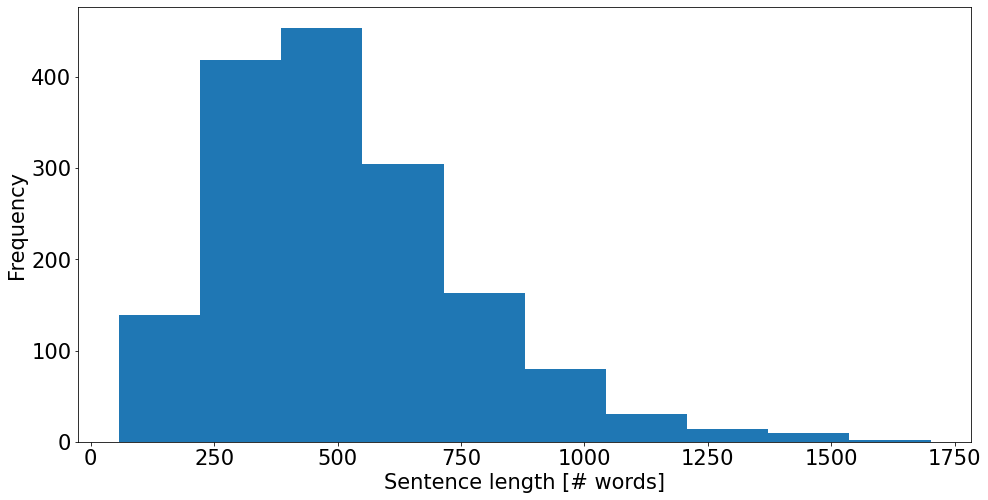

In [218]:
display(Markdown('## Our dataset'))
storage_folder = Path('../../data/old_datasets')
train, val, test = load_datasets(storage_folder)
plot_sentence_lengths(train)

In [17]:
display(Markdown('## OxAI dataset'))
storage_folder = Path('../../data/new_datasets')
train, val, test = load_datasets(storage_folder)
plot_sentence_lengths(train)

## OxAI dataset

## WordVec velocity

In [18]:
val.head(2)

l_lineLayer  l_lineIndex  l_cutDirection  \
name difficulty snippet time                                              
30ef Expert     0       6.276            0            0               8   
                        6.937            2            2               8   

                               r_lineLayer  r_lineIndex  r_cutDirection  \
name difficulty snippet time                                              
30ef Expert     0       6.276            0            1               8   
                        6.937            2            3               8   

                                    word   prev   next      part  ...  \
name difficulty snippet time                                      ...   
30ef Expert     0       6.276  L008_R018  0.660  0.661  0.019023  ...   
                        6.937  L228_R238  0.661  0.660  0.021027  ...   

                                                                        word_vec  \
name difficulty snippet time                                                       
30ef Expert     0       6.276  [0.06204, 0.802, -0.0704, -0.4146, -0.1514, -0...   
                        6.937  [0.4087, 0.288, -0.0749, -0.3352, 0.0555, -0.3...   

                              word_id  prev_l_lineLayer  prev_l_lineIndex  \
name difficulty snippet time                                                
30ef Expert     0       6.276     370                 0                 2   
                        6.937     371                 0                 0   

                               prev_l_cutDirection  prev_r_lineLayer  \
name difficulty snippet time                                           
30ef Expert     0       6.276                    8                 0   
                        6.937                    8                 0   

                               prev_r_lineIndex  prev_r_cutDirection  \
name difficulty snippet time                                           
30ef Expert     0       6.276                 3                    8   
                        6.937                 1                    8   

                                                                   prev_word_vec  \
name difficulty snippet time                                                       
30ef Expert     0       6.276  [-0.011314, 0.6533, -0.1385, -0.4766, -0.1547,...   
                        6.937  [0.06204, 0.802, -0.0704, -0.4146, -0.1514, -0...   

                              prev_word_id  
name difficulty snippet time                
30ef Expert     0       6.276        392.0  
                        6.937        370.0  

[2 rows x 21 columns]

In [20]:
# def create_sentence(x):
#     x.name = 'word'
#     x = x.reset_index('time')
#     x = x.drop_duplicates('time')
#     x = x.word.str.cat(sep=' ')
#     return x

# def word_df2text(df: pd.DataFrame):
#     return df.droplevel(2).word.groupby(['name', 'difficulty']).apply(create_sentence).str.cat(sep='\n')
nodup = val.droplevel(2)
nodup = nodup.loc[~nodup.index.duplicated()]
nodup.head(2)

l_lineLayer  l_lineIndex  l_cutDirection  r_lineLayer  \
name difficulty time                                                           
30ef Expert     6.276            0            0               8            0   
                6.937            2            2               8            2   

                       r_lineIndex  r_cutDirection       word   prev   next  \
name difficulty time                                                          
30ef Expert     6.276            1               8  L008_R018  0.660  0.661   
                6.937            3               8  L228_R238  0.661  0.660   

                           part  ...  \
name difficulty time             ...   
30ef Expert     6.276  0.019023  ...   
                6.937  0.021027  ...   

                                                                word_vec  \
name difficulty time                                                       
30ef Expert     6.276  [0.06204, 0.802, -0.0704, -0.4146, -0.1514, -0...   
                6.937  [0.4087, 0.288, -0.0749, -0.3352, 0.0555, -0.3...   

                      word_id  prev_l_lineLayer  prev_l_lineIndex  \
name difficulty time                                                
30ef Expert     6.276     370                 0                 2   
                6.937     371                 0                 0   

                       prev_l_cutDirection  prev_r_lineLayer  \
name difficulty time                                           
30ef Expert     6.276                    8                 0   
                6.937                    8                 0   

                       prev_r_lineIndex  prev_r_cutDirection  \
name difficulty time                                           
30ef Expert     6.276                 3                    8   
                6.937                 1                    8   

                                                           prev_word_vec  \
name difficulty time                                                       
30ef Expert     6.276  [-0.011314, 0.6533, -0.1385, -0.4766, -0.1547,...   
                6.937  [0.06204, 0.802, -0.0704, -0.4146, -0.1514, -0...   

                      prev_word_id  
name difficulty time                
30ef Expert     6.276        392.0  
                6.937        370.0  

[2 rows x 21 columns]

In [21]:
nodup.word_vec

name  difficulty  time  
30ef  Expert      6.276     [0.06204, 0.802, -0.0704, -0.4146, -0.1514, -0...
                  6.937     [0.4087, 0.288, -0.0749, -0.3352, 0.0555, -0.3...
                  7.597     [0.0726, 0.3982, -0.1726, -0.2705, -0.2386, 0....
                  8.093     [-0.313, -0.636, -0.1244, 0.0874, -0.3857, 0.3...
                  8.258     [-0.3596, -0.1683, -0.335, -0.2322, 0.07153, 0...
                                                  ...                        
5695  Normal      84.300    [0.2656, -0.1178, 0.3367, 0.0794, 0.1754, -0.1...
                  84.900    [0.1613, -0.1322, 0.2355, 0.2925, 0.2151, 0.22...
                  85.500    [0.03885, -0.5884, 0.0778, -0.1375, -0.1312, 0...
                  86.100    [0.00938, -0.3953, 0.1516, -0.1353, -0.03183, ...
                  86.700    [-0.02002, 0.11383, 0.1425, -0.02528, 0.178, -...
Name: word_vec, Length: 120702, dtype: object

In [81]:
import numpy as np

top = 9000
res = pd.DataFrame(np.array(nodup.word_vec.values.tolist())[:top], index=nodup.index[:top])
res

0         1         2         3         4    \
name difficulty time                                                       
30ef Expert     6.276   0.062042  0.801758 -0.070374 -0.414551 -0.151367   
                6.937   0.408691  0.288086 -0.074890 -0.335205  0.055511   
                7.597   0.072571  0.398193 -0.172607 -0.270508 -0.238647   
                8.093  -0.312988 -0.636230 -0.124390  0.087402 -0.385742   
                8.258  -0.359619 -0.168335 -0.334961 -0.232178  0.071533   
...                          ...       ...       ...       ...       ...   
32c6 Expert     13.908 -0.264160 -0.186523 -0.207764 -0.286621  0.098267   
                14.377 -0.109619  0.051422 -0.152222 -0.283936  0.199829   
                14.845 -0.264160 -0.186523 -0.207764 -0.286621  0.098267   
                15.314  0.128296  0.236572 -0.263184  0.004379 -0.351562   
                15.783  0.192017  0.086365  0.074524 -0.185913  0.560547   

                             5         6         7         8         9    ...  \
name difficulty time                                                      ...   
30ef Expert     6.276  -0.282227  0.133545 -0.202637 -0.400635  0.625977  ...   
                6.937  -0.324707  0.166016 -0.373047 -0.314697  0.365723  ...   
                7.597   0.024017  0.300781 -0.329346 -0.553711  0.089478  ...   
                8.093   0.379639 -0.260986  0.687988 -0.532227 -0.638184  ...   
                8.258   0.583496 -0.164917  0.536133 -0.556152 -0.810547  ...   
...                          ...       ...       ...       ...       ...  ...   
32c6 Expert     13.908 -0.125977 -0.009277  0.279541 -0.254639 -0.004940  ...   
                14.377  0.129639 -0.059387  0.300781 -0.002277  0.181763  ...   
                14.845 -0.125977 -0.009277  0.279541 -0.254639 -0.004940  ...   
                15.314  0.267334  0.181152  0.535645 -0.107910  0.527832  ...   
                15.783 -0.478271 -0.107788 -0.203125  0.004852  0.128052  ...   

                             246       247       248       249       250  \
name difficulty time                                                       
30ef Expert     6.276  -0.536133 -1.173828 -0.283203  0.595703 -0.522949   
                6.937  -0.086548 -0.296143 -0.335205  0.463623 -0.337158   
                7.597  -0.355713 -0.560059 -0.399658  0.494385 -0.292236   
                8.093   0.628906 -0.182495 -0.072937 -0.398682  0.122070   
                8.258   0.581543  0.176514  0.364502 -0.031647  0.240845   
...                          ...       ...       ...       ...       ...   
32c6 Expert     13.908 -0.331543 -0.441895 -0.670410 -0.246216 -0.513672   
                14.377 -0.044250 -0.393066 -0.435303  0.169556 -1.041016   
                14.845 -0.331543 -0.441895 -0.670410 -0.246216 -0.513672   
                15.314  0.514648  0.165283  0.421143  0.136597 -0.055756   
                15.783 -0.576172 -0.060211 -0.303223  0.237061 -0.551758   

                             251       252       253       254       255  
name difficulty time                                                      
30ef Expert     6.276   0.612793  0.054932 -0.343018 -0.354248  0.419922  
                6.937   0.110718 -0.221802 -0.517090 -0.413574  0.608398  
                7.597   0.229980 -0.232300 -0.437012 -0.072510  0.498779  
                8.093  -0.494385  0.038330 -0.218262 -0.561035 -0.263916  
                8.258  -0.395020  0.471680  0.619629  0.337646 -0.732910  
...                          ...       ...       ...       ...       ...  
32c6 Expert     13.908  0.140015 -0.624512 -0.753418 -0.685547  0.103210  
                14.377  0.472412 -0.425781 -0.577148 -0.612793 -0.045044  
                14.845  0.140015 -0.624512 -0.753418 -0.685547  0.103210  
                15.314 -0.194824  0.329102 -0.089600 -0.307129 -0.147827  
                15.783  0.582031 -0.531738 -0.361328 -0.007179 -0.042969  

[9000 rows x 256 colu

In [132]:
a, b = [1, 2, 3], [1, 0, 1]
np.dot(a, b)

4

In [134]:
np.sum(np.array(a) * b)

4

In [141]:
from scipy.spatial import distance

def cosine_dist(a, b):
    return 1 - np.sum(a * b, axis=-1)  / (np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1))

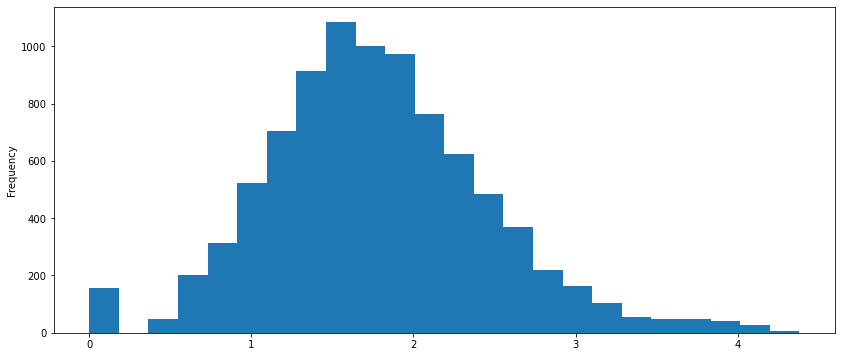

In [175]:
def process_snippet(df):
    means = df.iloc[::].rolling(7, win_type='boxcar').mean(std=7, tau=7, sym=False)

#     velocity  = cosine_dist(means.values, means.shift(4).values)
    diff = means - means.shift(4)
    velocity = ((diff.dropna()**2).sum(axis=1))**(1/2)
    return pd.Series(velocity).dropna()

# means = res.groupby(['name', 'difficulty', 'snippet']).rolling(30).mean().dropna()
# velocity = means - means.shift(1)
# ((velocity**2).sum(axis=1)**(1/2)).reset_index(drop=True).plot()
# means
res.groupby(['name', 'difficulty']).apply(process_snippet).plot.hist(bins=24, figsize=(14, 6))

## LaTeX DataFrame output

In [183]:
storage_folder = Path('../../data/old_datasets')
train, val, test = load_datasets(storage_folder)
val.index.to_frame().name.unique()[:100]

array(['AMENOHOAKARI', 'Adventure of a Lifetime',
       'All Time Low (BOXINLION Remix)', 'Alone Slushii Remix', 'Always',
       'Armed And Ready', 'BABYMETAL-Starlight', 'BRAVE JEWEL (TV size)',
       'Bangarang', 'Beat it', 'Becoming', 'Black Rover (TV Size)',
       'Bonfire', 'Bottle of Jack - Mikey Wax',
       'Boulevard of Broken Dreams', 'Bring it Back - Tisoki',
       'Careless Whisper', 'Closer', 'Conqueror', 'Courage',
       'Crack Traxxxx', 'Crawling', 'Crossing Field',
       'Darkside - Alan Walker', 'EC1-Rio', 'Fire Hive (Rickput)',
       'Flat Zone 2', 'Good Morning USA', 'Goodbye to A World',
       'Heaven Rd 2', "Hideki Naganuma - AIN'T NOTHIN' LIKE A FUNKY BEAT",
       'High Hopes', 'Hitorigoto - ClariS', 'Hype feat. Such',
       'Hyper Drive', 'Hysteria', 'I Knew You Were In Trouble',
       'I Took A Pill In Ibiza (SeeB Remix)', 'I nyaned for Hours',
       'Ignite (SAO)', 'John Powell - Test Drive', 'Jump Up, Super Star!',
       'LAST GAME (TV-Size)', 'L

In [116]:
storage_folder = Path('../../data/new_datasets')
train, val, test = load_datasets(storage_folder)
print(val.head().to_latex())
print(val.columns)
val.iloc[500:600].head()

\begin{tabular}{llllrrrrrrlrrrllrrrrrrrlr}
\toprule
     &        &   &       &  l\_lineLayer &  l\_lineIndex &  l\_cutDirection &  r\_lineLayer &  r\_lineIndex &  r\_cutDirection &       word &   prev &   next &      part &                                               mfcc &                                           word\_vec &  word\_id &  prev\_l\_lineLayer &  prev\_l\_lineIndex &  prev\_l\_cutDirection &  prev\_r\_lineLayer &  prev\_r\_lineIndex &  prev\_r\_cutDirection &                                      prev\_word\_vec &  prev\_word\_id \\
name & difficulty & snippet & time &              &              &                 &              &              &                 &            &        &        &           &                                                    &                                                    &          &                   &                   &                      &                   &                   &                      &                          

l_lineLayer  l_lineIndex  l_cutDirection  \
name difficulty snippet time                                               
30ef Expert     250     90.918            0            2               1   
                        91.249            1            0               2   
                        91.420            0            1               1   
                        91.579            0            3               7   
                        91.751            0            0               6   

                                r_lineLayer  r_lineIndex  r_cutDirection  \
name difficulty snippet time                                               
30ef Expert     250     90.918            0            3               1   
                        91.249            1            0               2   
                        91.420            0            2               1   
                        91.579            0            3               7   
                        91.751            0            0               6   

                                     word   prev   next      part  ...  \
name difficulty snippet time                                       ...   
30ef Expert     250     90.918  L021_R031  0.330  0.331  0.275581  ...   
                        91.249       L102  0.331  0.171  0.276584  ...   
                        91.420  L011_R021  0.171  0.159  0.277103  ...   
                        91.579       R037  0.159  0.172  0.277584  ...   
                        91.751       L006  0.172  0.158  0.278106  ...   

                                                                         word_vec  \
name difficulty snippet time                                                        
30ef Expert     250     90.918  [-0.2642, -0.1865, -0.2078, -0.2866, 0.09827, ...   
                        91.249  [0.2184, 0.0528, 0.561, -0.0498, -0.0955, 0.40...   
                        91.420  [-0.02002, 0.11383, 0.1425, -0.02528, 0.178, -...   
                        91.579  [-0.3286, -0.305, 0.003819, -0.01487, 0.3926, ...   
                        91.751  [-0.3596, -0.1683, -0.335, -0.2322, 0.07153, 0...   

                               word_id  prev_l_lineLayer  prev_l_lineIndex  \
name difficulty snippet time                                                 
30ef Expert     250     90.918      88                 1                 3   
                        91.249       4                 0                 2   
                        91.420      25                 1                 0   
                        91.579      63                 0                 1   
                        91.751      79                 0                 3   

                                prev_l_cutDirection  prev_r_lineLayer  \
name difficulty snippet time                                            
30ef Expert     250     90.918                    3                 1   
                        91.249                    1                 0   
                        91.420                    2                 1   
                        91.579                    1                 0   
                        91.751                    7                 0   

                                prev_r_lineIndex  prev_r_cutDirection  \
name difficulty snippet time                                            
30ef Expert     250     90.918                 3                    3   
                        91.249                 3                    1   
                        91.420                 0                    2   
                        91.579                 2                    1   
                        91.751                 3                    7   

                                                                    prev_word_vec  \
name difficulty snippet time                                                        
30ef Expert     250     90.918  [0.5366, -0.287, 0.8335, -0.02771, 0.5464, 0.1...   
                        9

## Data changes exploration

In [118]:
storage_folder = Path('../../data/new_datasets_config_test') # 26 + 26
train, val, test = load_datasets(storage_folder)

In [130]:
val.index.to_frame().difficulty.unique()

array(['Expert', 'Hard', 'Normal', 'ExpertPlus', 'Easy'], dtype=object)

In [143]:
len(set(train.word.unique()) - set(train.xs('ExpertPlus', level='difficulty').word.unique()))

297

In [151]:
len(set(train.xs('ExpertPlus', level='difficulty').word.unique()) & set(train.word.unique()))

2192

In [150]:
len(train.word.unique())- 297 - 2192

2489

In [89]:
class ArbitraryDataclass():
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)
            
class DataDict():
    def __init__(self):
        self.__dict = {}
        
    def __setitem__(self, key, val):
        self.__dict[key] = ArbitraryDataclass(**val)
        
    def __getitem__(self, key):
        return self.__dict[key]

models = ['m1', 'm2', ]
data = DataDict()

def data_prep(data, models):
    for m in models:
        a = m + '-a'
        b = m + '-b'
        data[m] = locals()

def visualize(data, models):
    for m in models:
        l = data[m]
        print(l.a, l.b, )

data_prep(data, models)
visualize(data, models)

data['m1'].train

m1-a m1-b
m2-a m2-b


AttributeError: 'ArbitraryDataclass' object has no attribute 'train'

In [84]:
q = 'asd'

In [56]:
d['m']

KeyError: 'm'